# Библиотеки

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import os
from natsort import natsorted, ns
import matplotlib.pyplot as plt
import operator

import keras
from keras.models import Model, Sequential, model_from_json
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.utils import np_utils

import cv2
from tqdm import tqdm

from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


# Загрузка и обработка данных

In [2]:
core_dir = 'C:\\Users\\horch\\Desktop\\Local_data\\'
#core_dir = 'C:\\Kaggle\\Understanding the Amazon from Space\\'
#core_dir = 'D:\\Kaggle\\Understanding the Amazon from Space\\'

train_dir = core_dir + 'train-jpg\\'
test_dir = core_dir + 'test-jpg\\'
test_data_names = natsorted(os.listdir(test_dir), key=lambda y: y.lower())


cathegories = ['agriculture', 'artisinal_mine', 'bare_ground', 
                      'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 
                      'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 
                      'road', 'selective_logging', 'slash_burn', 'water']

#train_data = pd.read_csv(core_dir + 'train.csv')
train_data = pd.read_csv(core_dir + 'train_v2.csv')
train_data.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


# Функции

подготовка тренировочной выборки по имени категории
принимает категорию, возвращает массив из 0 и 1 (1 - файл содержит категорию, 0 - иначе)

In [3]:
def TrainingSetByCathegory(cathegory):
    df = pd.DataFrame()
    
    df['image_name'] = train_data.image_name.values
    df['indicator'] = np.zeros(train_data.shape[0])
    
    df.loc[df['image_name'].isin(cathegory_dict[cathegory]), ['indicator']] = 1
    
    return df.indicator.values

формирование полной (по всем категориям) тестовой выборки

In [4]:
def TestSetWhole(data, col_name = 'tags'):
    encoder = LabelEncoder()
    encoder.fit(cathegories)
    
    result = np.zeros((data.shape[0], len(cathegories)))
    
    for i in range(data.shape[0]):
        tag = data[col_name][i]
        tag = tag.split(' ')
        v = encoder.transform(tag)
        
        for j in v:
            result[i, j] = 1
    
    return(result)

функция предназначенная для конвертации .jpg изображения в numpy массив
если transparency = False, то каждая точка представляется 3 числами иначе - 4

In [5]:
def ImageToNumpy(img_name, img_dir = train_dir, img_type = '.jpg', transparency = False):
    img = Image.open(train_dir + img_name + img_type)
    img.load()
    data = np.asarray( img, dtype="int32" )
    img.close()
    
    if transparency:
        return data
    else:
        return data[:, :, 0:3]

функция для конвертации вектора компоненты которого принадлежат [0, 1] в вектор из 0 и 1 при заданном пороге (treshold)

In [6]:
def BinimialPrediction(x, treshold = 0.5):
    result = np.zeros(x.shape)
    
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if x[i, j] >= treshold:
                result[i, j] = 1
    
    return(result)

def FBettaScore(x_true, x_predicted, betta = 2):
    if len(x_true) == len(x_predicted):
        tp = 0
        fp = 0
        fn = 0

        for i in range(len(x_predicted)):
            if x_true[i] == 1 and x_predicted[i] == 1:
                tp += 1
            
            if x_true[i] == 0 and x_predicted[i] == 1:
                fp += 1
            
            if x_true[i] == 1 and x_predicted[i] == 0:
                fn += 1
        
        if tp == 0 or (tp + fp) == 0 or (tp + fn) == 0:
            return(0)
        else:
            precision = tp/(tp + fp)
            recall = tp/(tp + fn)
            
            #print(precision, recall)
            return((1 + betta**2)*precision*recall/(betta**2*precision + recall))
    else:
        print('FBettaScore error! len(x_true) != len(x_predicted)')

def AvgFBettaScore(x_true, x_predicted, betta = 2):
    result = 0
    n = x_true.shape[0]
    
    x_predicted = BinimialPrediction(x_predicted)
    
    for i in range(n):
        result += FBettaScore(x_true[i, :], x_predicted[i, :], betta)
    
    return(result/n)


# Вычисления

создадим словарь категорий
каждой категории будет соответствовать список файлов, в которых данная категория присутствует

In [7]:
cathegory_dict = {cathegory: [] for cathegory in cathegories}

ind = 0
for tag in train_data.tags.values:
    file_name = train_data.image_name[ind]
    
    cathegory_names_list = tag.split(' ')
    
    for cathegory in cathegory_names_list:
        cathegory_dict[cathegory].append(file_name)
    
    ind += 1   

формирование обучающей выборки

In [8]:
X = []

for img_name in tqdm(train_data.image_name.values):
    
    img = cv2.imread(train_dir + img_name + '.jpg')
    res = cv2.resize(img, (32, 32))
    X.append(res)
    
X = np.array(X, np.float16) / 255.

100%|███████████████████████████████████| 40479/40479 [01:56<00:00, 346.20it/s]


формирование тестовой выборки

In [10]:
Y = TestSetWhole(train_data)

разбиение выборки на обучение и тест

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Настройка и  обучение сети для всех категорий

In [18]:
batch_size = 128 # in each iteration, we consider 32 training examples at once
num_epochs = 500 # we iterate 200 times over the entire training set
kernel_size = 3 # we will use 3x3 kernels throughout
pool_size = 2 # we will use 2x2 pooling throughout
conv_depth_1 = 32 # we will initially have 32 kernels per conv. layer...
conv_depth_2 = 64 # ...switching to 64 after the first pooling layer
drop_prob_1 = 0.25 # dropout after pooling with probability 0.25
drop_prob_2 = 0.5 # dropout in the FC layer with probability 0.5
hidden_size = 512 # the FC layer will have 512 neurons

In [15]:
# загрузка изображений и их приведение к подходящему для обработки виду
num_train = X.shape[0]
depth = 32 
height = 32
width = 3 

num_classes = len(cathegories)

#y_train = TrainingSetByCathegory(cathegories[0]) #y_train labels (для категории_0 1, если подходит, 0-иначе)
#Y_train = np_utils.to_categorical(y_train, num_classes) # One-hot encode the labels
#X_train = X

In [16]:
# переделать
'''
def f2_metric(y_true, y_pred):
    result = []
    for i in range(y_true.shape[0]):
        result.append(fbeta_score(y_true[i, :], y_pred[i, :], 2))
    
    result = np.mean(result)
    
    return(result)
'''

'\ndef f2_metric(y_true, y_pred):\n    result = []\n    for i in range(y_true.shape[0]):\n        result.append(fbeta_score(y_true[i, :], y_pred[i, :], 2))\n    \n    result = np.mean(result)\n    \n    return(result)\n'

In [19]:
inp = Input(shape=(depth, height, width)) # N.B. depth goes first in Keras!

# Conv [32] -> Conv [32] -> Pool (with dropout on the pooling layer)

conv_1 = Convolution2D(conv_depth_1, kernel_size, kernel_size, border_mode='same', activation='relu')(inp)
conv_2 = Convolution2D(conv_depth_1, kernel_size, kernel_size, border_mode='same', activation='relu')(conv_1)
pool_1 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_2)
drop_1 = Dropout(drop_prob_1)(pool_1)

# Conv [64] -> Conv [64] -> Pool (with dropout on the pooling layer)

conv_3 = Convolution2D(conv_depth_2, kernel_size, kernel_size, border_mode='same', activation='relu')(drop_1)
conv_4 = Convolution2D(conv_depth_2, kernel_size, kernel_size, border_mode='same', activation='relu')(conv_3)
pool_2 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_4)
drop_2 = Dropout(drop_prob_1)(pool_2)

# Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax

flat = Flatten()(drop_2)

hidden = Dense(hidden_size, activation='relu')(flat)

drop_3 = Dropout(drop_prob_2)(hidden)

out = Dense(num_classes, activation='sigmoid')(drop_3)

model = Model(input=inp, output=out) # To define a model, just specify its input and output layers

model.compile(loss='binary_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy

model.fit(x_train, y_train, # Train the model using the training set...
          batch_size=batch_size, nb_epoch=num_epochs,
          verbose=1, validation_split=0.2) # ...holding out 10% of the data for validation

#model.evaluate(x_test, y_test, verbose=1) # Evaluate the trained model on the test set!
cnn_prediction = model.predict(x_test)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:35: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 22668 samples, validate on 5667 samples
Epoch 1/500
22668/22668 [==============================] - 106s - loss: 0.2421 - acc: 0.9076 - val_loss: 0.2051 - val_acc: 0.9173
Epoch 2/500
22668/22668 [==============================] - 102s - loss: 0.1897 - acc: 0.9252 - val_loss: 0.1739 - val_acc: 0.9311
Epoch 3/500
22668/22668 [==============================] - 104s - loss: 0.1707 - acc: 0.9331 - val_loss: 0.1657 - val_acc: 0.9353
Epoch 4/500
22668/22668 [==============================] - 106s - loss: 0.1608 - acc: 0.9366 - val_loss: 0.1735 - val_acc: 0.9317
Epoch 5/500
22668/22668 [==============================] - 105s - loss: 0.1582 - acc: 0.9379 - val_loss: 0.1480 - val_acc: 0.9407
Epoch 6/500
22668/22668 [==============================] - 102s - loss: 0.1478 - acc: 0.9419 - val_loss: 0.1500 - val_acc: 0.9404
Epoch 7/500
22668/22668 [==============================] - 103s - loss: 0.1468 - acc: 0.9421 - val_loss: 0.1460 - val_acc: 0.9430
Epoch 8/500
22668/22668 [================

In [20]:
# Генерируем описание модели в формате json
model_json = model.to_json()
# Записываем модель в файл
json_file = open("model_v1_500e.json", "w")
json_file.write(model_json)
json_file.close()

model.save_weights("model_v1_500e.h5")

## Делаем предсказание

In [12]:
# load json and create model
json_file = open(core_dir+'model_v1_500e.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights(core_dir+'model_v1_500e.h5')
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Loaded model from disk


In [13]:
test_prediction = loaded_model.predict(x_test)

In [14]:
def CatchErrors_hist(true_data, predict_data, treshhold):
    bin_pred = BinimialPrediction(predict_data, treshold = treshhold)
    error_cats = []
    for i in range(len(bin_pred)):
        for j in range(len(bin_pred[0])):
            if bin_pred[i][j] != true_data[i][j]:
                error_cats.append(cathegories[j])
    dict_err = {}
    for i in error_cats:
        if i in dict_err:
            dict_err[i] += 1
        else:
            dict_err[i] = 1
    #sorted_dict = sorted(dict_err.items(), key=operator.itemgetter(1))        
    plt.figure(figsize=(20,10))
    plt.bar(range(len(dict_err)), dict_err.values(), align='center')
    plt.xticks(range(len(dict_err)), dict_err.keys(), rotation=40, size = 15)            
            
    return plt.show()          

In [20]:
def CatchErrors(true_data, predict_data, treshhold):
    bin_pred = BinimialPrediction(predict_data, treshold = treshhold)
    error_cats = []
    for i in range(len(bin_pred)):
        for j in range(len(bin_pred[0])):
            if bin_pred[i][j] != true_data[i][j]:
                error_cats.append(cathegories[j])
    dict_err = {}
    for i in error_cats:
        if i in dict_err:
            dict_err[i] += 1
        else:
            dict_err[i] = 1
           
           
    return dict_err  

In [161]:
def TableOfErrors(treshholds):
    data = []
    for i in range(len(treshholds)):
        data.append((CatchErrors(y_test, test_prediction,treshholds[i])))
    df = pd.DataFrame(data, index = treshholds)
    return df

In [165]:
treshholds = np.arange(0, 1.0, 0.01)
table_1000 = TableOfErrors(treshholds)

In [188]:
table_1000

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0.00,8495,12043,11872,12041,12110,3571,11534,12119,10841,11052,11353,9974,885,9801,12039,12077,9990
0.01,1935,112,465,184,42,996,369,30,2046,1617,867,616,633,2104,142,94,2487
0.02,1830,103,402,155,36,902,351,27,1863,1498,779,570,593,1952,128,84,2208
0.03,1791,98,375,137,36,850,331,27,1735,1421,730,545,566,1883,124,83,2091
0.04,1761,99,355,132,35,831,313,27,1653,1356,702,529,551,1836,119,81,1988
0.05,1746,98,342,128,35,807,303,27,1626,1314,677,518,539,1796,116,80,1932
0.06,1721,97,332,124,34,792,291,26,1584,1273,657,514,523,1767,114,79,1868
0.07,1714,95,328,123,34,779,283,26,1551,1251,647,511,514,1735,114,76,1834
0.08,1704,96,327,120,34,768,276,26,1509,1227,627,508,503,1724,111,75,1795
0.09,1695,96,321,118,34,764,270,26,1483,1210,618,504,496,1714,110,73,1766


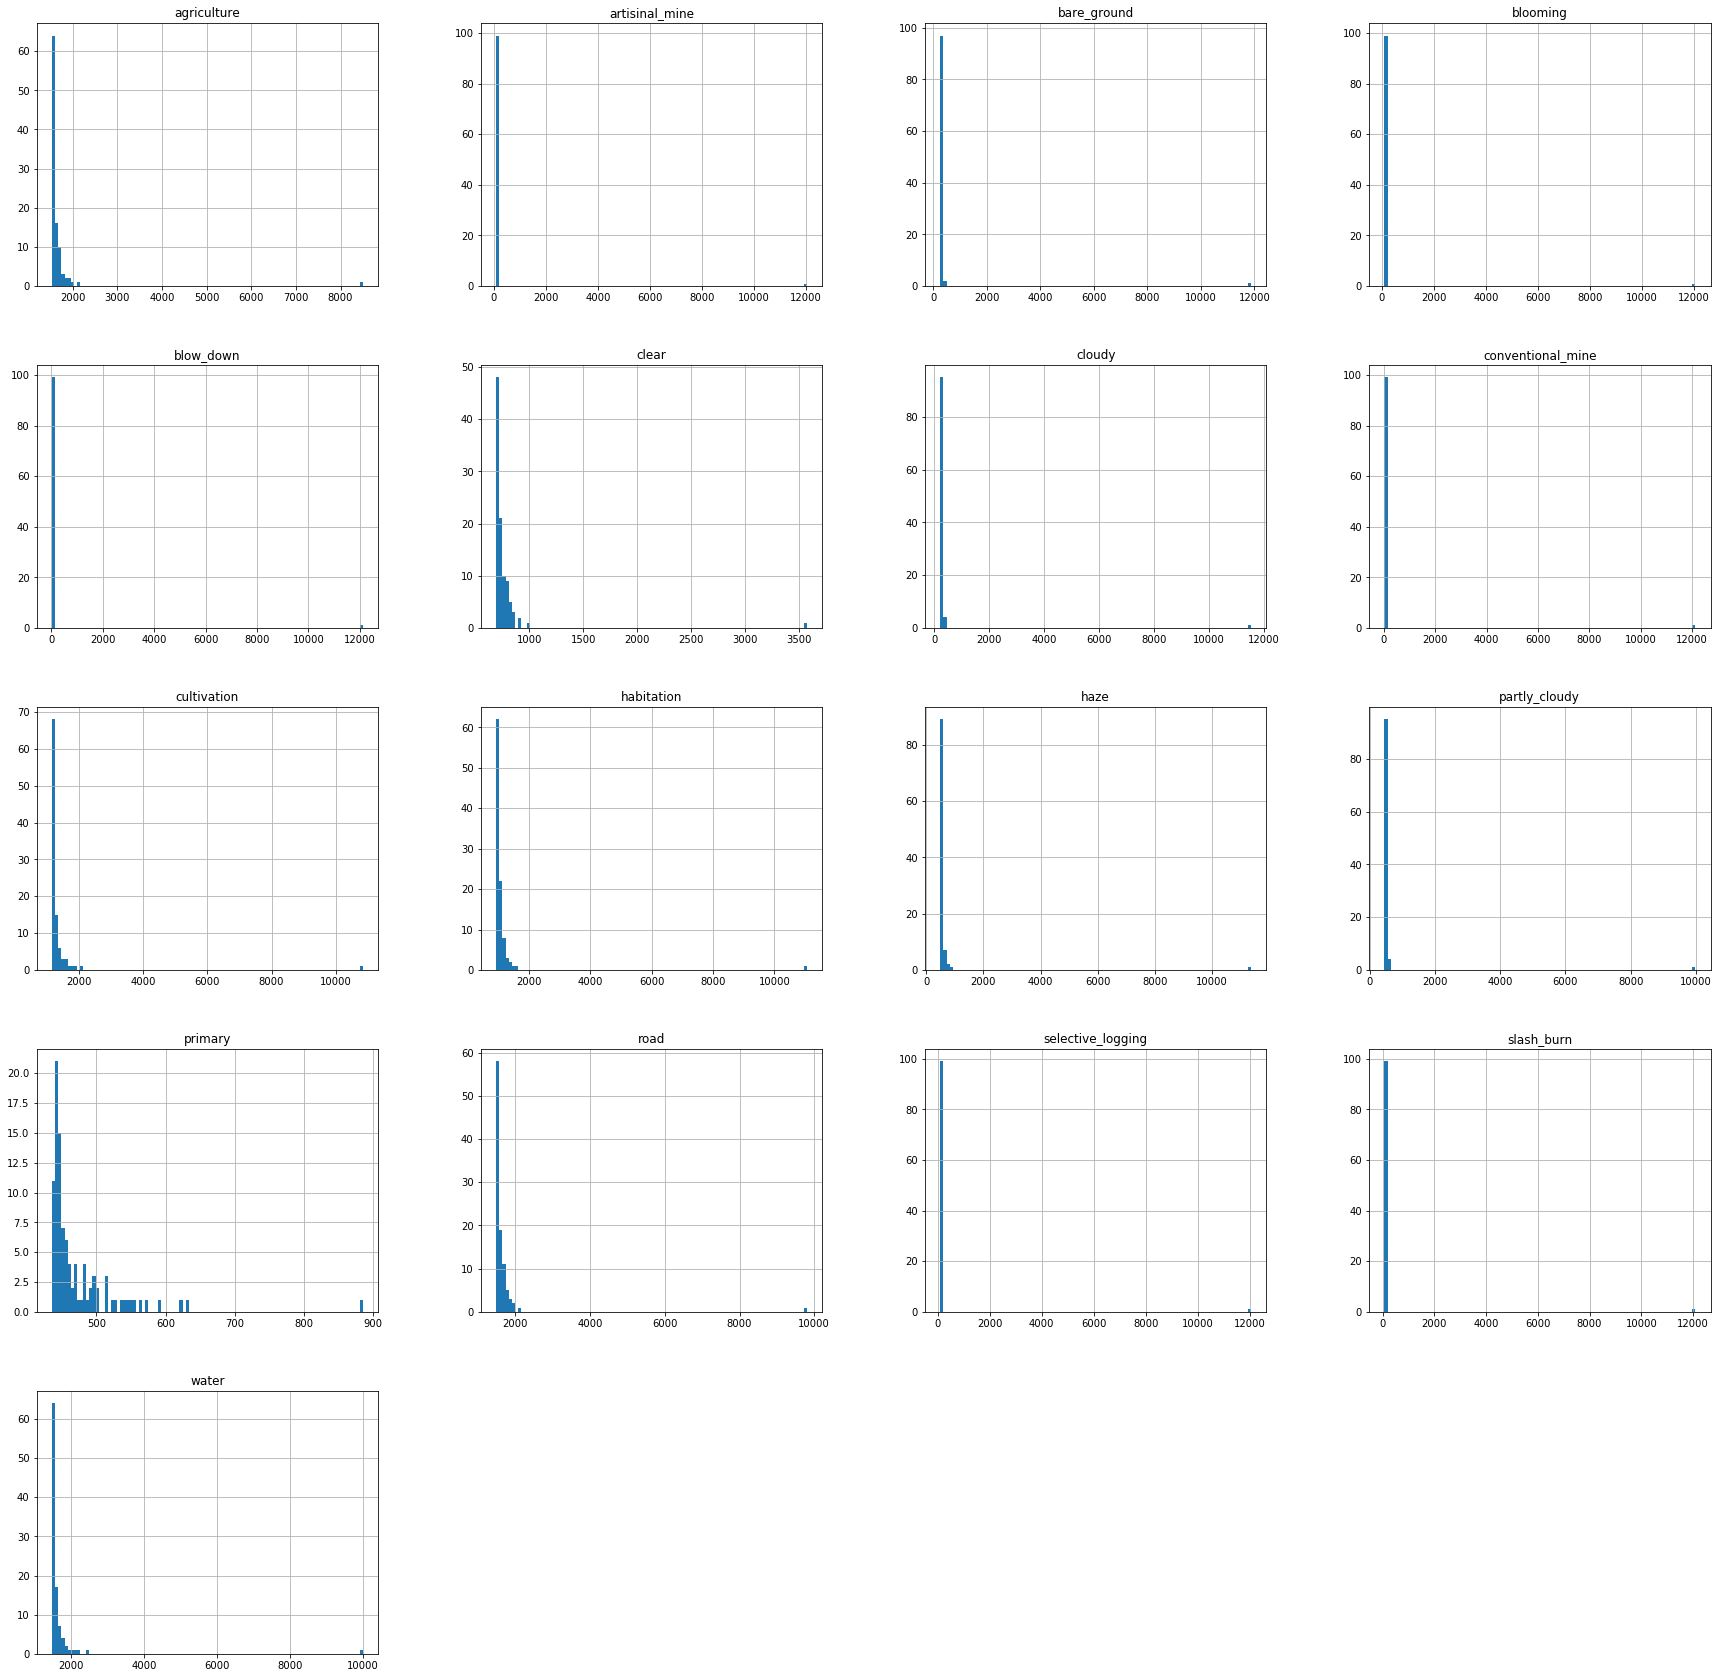

In [187]:
table_1000.hist(bins=100, figsize = [30,30])
plt.show()

In [176]:
table_1000.describe() 

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1686.230000,208.320000,402.470000,229.520000,154.300000,770.150000,364.670000,146.04000,1354.820000,1153.610000,646.030000,581.160000,474.290000,1678.740000,225.540000,189.240000,1663.800000
std,695.346783,1195.430457,1158.920548,1193.127505,1207.647003,288.043816,1128.691717,1209.39012,970.872901,1006.883339,1083.220371,949.251813,58.675153,828.734226,1193.290463,1200.791373,856.235477
min,1541.000000,84.000000,263.000000,103.000000,33.000000,693.000000,220.000000,24.00000,1153.000000,943.000000,496.000000,457.000000,436.000000,1489.000000,104.000000,67.000000,1468.000000
25%,1552.000000,86.000000,271.000000,104.000000,33.000000,702.750000,229.000000,25.00000,1171.750000,976.750000,504.000000,467.000000,444.000000,1514.500000,104.000000,67.000000,1487.750000
50%,1576.500000,87.000000,276.000000,107.000000,33.000000,723.000000,244.500000,25.00000,1191.000000,1019.000000,517.500000,473.000000,451.500000,1548.000000,105.000000,67.000000,1528.000000
75%,1640.500000,90.000000,294.000000,113.000000,34.000000,771.000000,264.000000,25.00000,1279.500000,1081.000000,542.000000,498.500000,484.000000,1641.000000,106.000000,69.000000,1607.500000
max,8495.000000,12043.000000,11872.000000,12041.000000,12110.000000,3571.000000,11534.000000,12119.00000,10841.000000,11052.000000,11353.000000,9974.000000,885.000000,9801.000000,12039.000000,12077.000000,9990.000000


In [54]:
csv_file_dir = local_dir + 'submission.csv'
submission_csv = open(csv_file_dir, 'w')
submission_csv.write('image_name, tags\n')

for i in tqdm(range(len(test_data_names))):
    if test_data_names[i].endswith("jpg"):
        line = test_data_names[i] + ','
        
        for j in range(len(img_prediction[i])):
            if img_prediction[i][j] >= 0.95:
                line += cathegories[j] + ' '

        submission_csv.write(line + '\n')
submission_csv.close()

100%|██████████████████████████████████| 40670/40670 [00:05<00:00, 6995.99it/s]


функция для формирования тестовой выборки

In [21]:
X_pred = []

for img_name in tqdm(test_data_names):
    if img_name.endswith("jpg"):
        img = cv2.imread(test_dir + img_name)
        res = cv2.resize(img, (32, 32))
        X_pred.append(res)
    else:
        print("This file is not jpg: " + img_name)
    
    
X_pred = np.array(X_pred, np.float16) / 255.

100%|████████████████████████████████████| 40669/40669 [19:55<00:00, 67.01it/s]


In [52]:
img_prediction = loaded_model.predict(X_pred)

In [53]:
img_prediction[9]

array([  9.95028913e-02,   2.44770731e-10,   1.46920516e-04,
         1.91186206e-10,   7.95338906e-09,   2.09312118e-03,
         2.11043917e-02,   1.89864000e-08,   2.01471034e-03,
         1.25273596e-04,   9.95246828e-01,   2.79361684e-05,
         9.94588614e-01,   8.99066925e-02,   6.53332544e-09,
         7.05595538e-09,   1.04903862e-01], dtype=float32)

In [22]:
natsorted(test_data_names, key=lambda y: y.lower())

['test_0.jpg',
 'test_1.jpg',
 'test_2.jpg',
 'test_3.jpg',
 'test_4.jpg',
 'test_5.jpg',
 'test_6.jpg',
 'test_7.jpg',
 'test_8.jpg',
 'test_9.jpg',
 'test_10.jpg',
 'test_11.jpg',
 'test_12.jpg',
 'test_13.jpg',
 'test_14.jpg',
 'test_15.jpg',
 'test_16.jpg',
 'test_17.jpg',
 'test_18.jpg',
 'test_19.jpg',
 'test_20.jpg',
 'test_21.jpg',
 'test_22.jpg',
 'test_23.jpg',
 'test_24.jpg',
 'test_25.jpg',
 'test_26.jpg',
 'test_27.jpg',
 'test_28.jpg',
 'test_29.jpg',
 'test_30.jpg',
 'test_31.jpg',
 'test_32.jpg',
 'test_33.jpg',
 'test_34.jpg',
 'test_35.jpg',
 'test_36.jpg',
 'test_37.jpg',
 'test_38.jpg',
 'test_39.jpg',
 'test_40.jpg',
 'test_41.jpg',
 'test_42.jpg',
 'test_43.jpg',
 'test_44.jpg',
 'test_45.jpg',
 'test_46.jpg',
 'test_47.jpg',
 'test_48.jpg',
 'test_49.jpg',
 'test_50.jpg',
 'test_51.jpg',
 'test_52.jpg',
 'test_53.jpg',
 'test_54.jpg',
 'test_55.jpg',
 'test_56.jpg',
 'test_57.jpg',
 'test_58.jpg',
 'test_59.jpg',
 'test_60.jpg',
 'test_61.jpg',
 'test_62.jpg',
 '

In [44]:
test_data_names[0].split('_')[1]

'0.jpg'